In [25]:
import pde
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy
import torch
import h5py

In [26]:
class MatReader(object):
    def __init__(self, file_path, to_torch=True, to_cuda=False, to_float=True):
        super(MatReader, self).__init__()

        self.to_torch = to_torch
        self.to_cuda = to_cuda
        self.to_float = to_float

        self.file_path = file_path

        self.data = None
        self.old_mat = None
        self._load_file()

    def _load_file(self):
        try:
            self.data = scipy.io.loadmat(self.file_path)
            self.old_mat = True
        except:
            self.data = h5py.File(self.file_path)
            self.old_mat = False

    def load_file(self, file_path):
        self.file_path = file_path
        self._load_file()

    def read_field(self, field):
        x = self.data[field]

        if not self.old_mat:
            x = x[()]
            x = np.transpose(x, axes=range(len(x.shape) - 1, -1, -1))

        if self.to_float:
            x = x.astype(np.float32)

        if self.to_torch:
            x = torch.from_numpy(x)

            if self.to_cuda:
                x = x.to(device)

        return x

    def set_cuda(self, to_cuda):
        self.to_cuda = to_cuda

    def set_torch(self, to_torch):
        self.to_torch = to_torch

    def set_float(self, to_float):
        self.to_float = to_float

In [58]:
# Subsampling rate
sampling_rate = 3
ntrain = 1000
ntest = 100
batch_size = 10


In [61]:
# Read and load data
def get_dataloaders(path, ntrain, ntest, batch_size, sampling_rate, grid_range = 1):
    sub = 2**sampling_rate
    reader = MatReader(path)
    x_data = reader.read_field("a")[:,::sub]
    y_data = reader.read_field("u")[:,::sub]
    size_x = x_data.shape[1]

    x_train, y_train = x_data[:ntrain,:], y_data[:ntrain,:]
    x_test, y_test = x_data[-ntest:,:], y_data[-ntest:,:]

    x_train = x_train[:, :, None]
    x_test = x_test[:, :, None]

    # Add grid
    gridx = torch.tensor(np.linspace(0, grid_range, size_x), dtype=torch.float)
    gridx = gridx.reshape(1, size_x, 1).repeat([ntrain, 1, 1])

    x_train = torch.cat((x_train, gridx), dim=-1)

    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train),
                                            batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test),
                                            batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

In [62]:
train_loader, test_loader = get_dataloaders('../data/burgers_data_R10.mat', ntrain, ntest, batch_size, sampling_rate)

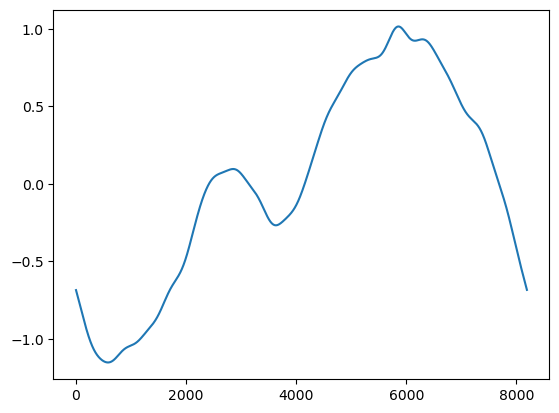

In [22]:
plt.plot(burgers_1d["a"][1000,:])

# 1d Kuramoto-Sivashinksky PDE

In [2]:
L = 250
# make 1D grid
grid = pde.CartesianGrid([(0, 60)], [L], periodic=True)

# initial condition: random field
state = pde.ScalarField.random_uniform(grid, vmin=-1, vmax=1)

# define Kuramoto-Sivashinksky PDE
eq = pde.PDE({"u": "-u * d_dx(u) / 2 - laplace(u + laplace(u))"})

# solve the system
storage = pde.MemoryStorage()
result = eq.solve(
state,
t_range=150,
dt=0.001,
adaptive=True,
tracker=["progress", storage.tracker(0.1)],
)



  0%|          | 0/150.0 [00:00<?, ?it/s]

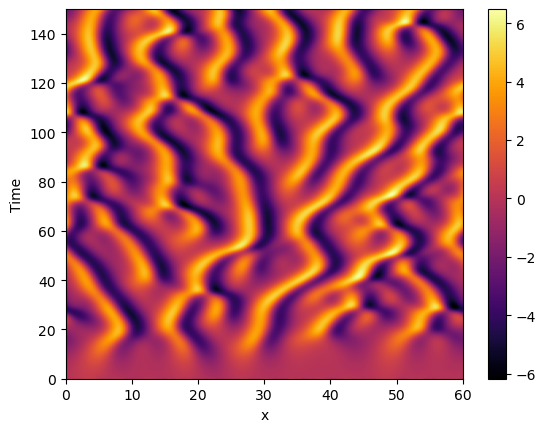

In [3]:
# plot the time evolution of the system
pde.plot_kymograph(storage, cmap = "inferno")

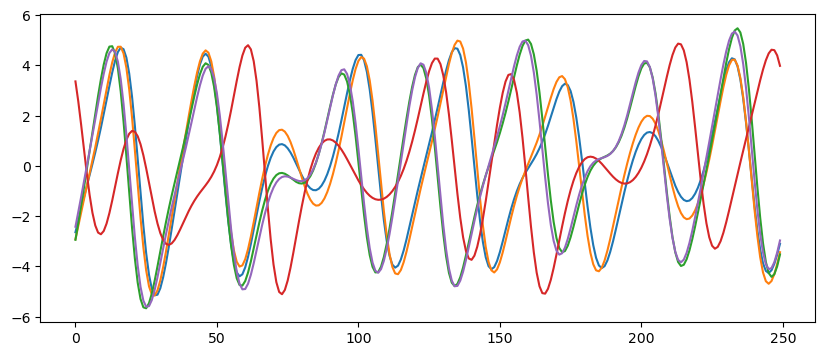

In [13]:
# Plot random time slices
n = 1500
n_plot = np.random.randint(0,n,5)
data_array = np.array(storage.data)[n_plot,:]

fig, axs = plt.subplots(figsize=(10, 4))
for i, x in enumerate(n_plot):
    axs.plot(data_array[i], label=f"t={x}")

# 2d Kuramoto-Sivashinksky PDE

In [18]:
L = 50
grid = pde.UnitGrid([L, L])  # generate grid
grid = pde.CartesianGrid([(0, L), (0,L)], [L,L], periodic = True)
state = pde.ScalarField.random_uniform(grid)  # generate initial condition

eq = pde.PDE({"u": "-gradient_squared(u) / 2 - laplace(u + laplace(u))"})  # define the pde


# solve the system
storage = pde.MemoryStorage()
result = eq.solve(
state,
t_range=150,
dt=0.001,
adaptive=True,
tracker=["progress", storage.tracker(20)],
)


  0%|          | 0/150.0 [00:00<?, ?it/s]

In [19]:
results = np.array(storage.data)

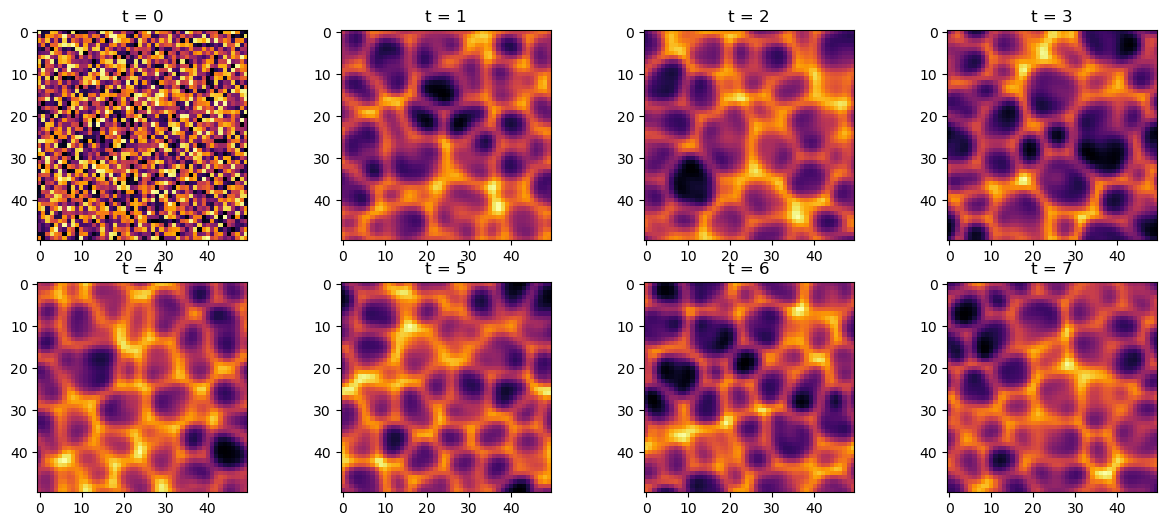

In [20]:
fig, axs = plt.subplots(2,4, figsize = (15,6))
axs= axs.ravel()

for i in range(results.shape[0]):
    axs[i].imshow(results[i], cmap = "inferno")
    axs[i].set_title("t = " + str(i))